In [1]:
import warnings
warnings.filterwarnings('ignore')

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Lesson 4*
On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophiscated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: what the hell are your documents about? Who might want to know that in industry - 
* Identifing common themes in customer reviews
* Discoverying the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* <a href="#p1">Part 1</a>: Describe how an LDA Model works
* <a href="#p2">Part 2</a>: Estimate a LDA Model with Gensim
* <a href="#p3">Part 3</a>: Interpret LDA results
* <a href="#p4">Part 4</a>: Select the appropriate number of topics

## Part 1: Latent Dirchilet Allocation (LDA) Models
<a id="#p1"></a>

LDA is a "generative probabilistic model". 

Let's play with a modoel available [here](https://lettier.com/projects/lda-topic-modeling/)

## Part 2: Estimating LDA Models with Gensim
<a id="#p1"></a>

### A Litterary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for litterary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similiar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelility of British women publishing novels during the early 19th century. 

Can we help close a litterary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [10]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chuncks

In [11]:
path = '../data/austen-brontë-split'

### Text Preprocessing
**Challenge**: update the function `tokenize` with any technique you have learned so far this week. 

In [6]:
titles = [t[:-4] for t in os.listdir(path)]

In [7]:
titles[:5]

['Austen_Emma0000',
 'Austen_Emma0001',
 'Austen_Emma0002',
 'Austen_Emma0003',
 'Austen_Emma0004']

In [12]:
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [13]:
tokenize("Hello World! This a test of the tokenization method")

['hello', 'world', 'test', 'tokenization', 'method']

### Author DataFrame


In [14]:
df = pd.DataFrame(index=titles)

In [15]:
df.head()

""
Austen_Emma0000
Austen_Emma0001
Austen_Emma0002
Austen_Emma0003
Austen_Emma0004


In [18]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [19]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [20]:
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our fucntion. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this fucntion later on. 

In [21]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            tokens = tokenize(str(text))
            yield tokens

### Gensim LDA Topic Modeling

In [22]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [23]:
id2word.doc2bow(tokenize("This is a sample message Darcy England England England"))

[(2754, 1), (3987, 3), (6602, 1), (6819, 1)]

In [32]:
import sys
sys.getsizeof(id2word)

56

In [33]:
len(id2word.keys())

22096

In [31]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=.10, no_above=0.75)

In [33]:
len(id2word.keys())

22093

In [34]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [35]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=4
                  )

In [37]:
lda.print_topics()

[(0,
  '0.005*"like" + 0.005*"bretton" + 0.004*"graham" + 0.004*"madame" + 0.004*"long" + 0.004*"dr" + 0.004*"thought" + 0.004*"night" + 0.004*"hand" + 0.003*"day"'),
 (1,
  '0.008*"jane" + 0.008*"sir" + 0.006*"like" + 0.005*"rochester" + 0.004*"room" + 0.004*"thought" + 0.004*"come" + 0.004*"night" + 0.004*"door" + 0.003*"know"'),
 (2,
  '0.020*"emma" + 0.013*"harriet" + 0.011*"miss" + 0.011*"weston" + 0.010*"knightley" + 0.009*"elton" + 0.008*"think" + 0.008*"thing" + 0.008*"woodhouse" + 0.007*"know"'),
 (3,
  '0.004*"thought" + 0.004*"like" + 0.004*"know" + 0.003*"monsieur" + 0.003*"mdlle" + 0.003*"john" + 0.003*"pelet" + 0.003*"eyes" + 0.003*"eye" + 0.003*"man"'),
 (4,
  '0.003*"man" + 0.003*"heart" + 0.002*"long" + 0.002*"church" + 0.002*"silas" + 0.002*"pere" + 0.002*"way" + 0.002*"like" + 0.002*"think" + 0.002*"paul"'),
 (5,
  '0.004*"st" + 0.004*"like" + 0.003*"day" + 0.003*"john" + 0.003*"thought" + 0.003*"know" + 0.003*"hunsden" + 0.003*"diana" + 0.003*"long" + 0.002*"house"'

In [38]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [39]:
topics = [' '.join(t[0:5]) for t in words]

In [40]:
print(topics[0])

like bretton graham madame long


## Part 3: Interpret LDA Results
<a id="#p3"></a>

### Topic Distance Visualization

In [41]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [42]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

/home/cowley/venv/U4-S1-NLP/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.181922  0.038941       1        1  31.222511
0      0.015655 -0.072243       2        1  15.104340
2     -0.167693  0.057569       3        1  10.818152
1     -0.012341 -0.055053       4        1   8.114708
11    -0.056548 -0.008893       5        1   7.981131
8     -0.013128 -0.029894       6        1   4.636999
3      0.021734 -0.029641       7        1   4.280366
5      0.019835 -0.040759       8        1   3.901208
14     0.029128 -0.040412       9        1   3.439704
10     0.046363 -0.054997      10        1   3.158427
9      0.024104 -0.004679      11        1   2.551756
6      0.036920 -0.035721      12        1   2.129267
12     0.024794  0.081015      13        1   1.109715
4      0.096317  0.090325      14        1   0.973620
7      0.116782  0.104442      15        1   0.578090, topic_info=      Category         Freq       Term        Total  loglift  logprob
90     Default   879.000000       emma   879.000000  30.0000  30.0000
1070   Default   532.000000    harriet   532.000000  29.0000  29.0000
311    Default   447.000000     weston   447.000000  28.0000  28.0000
414    Default   396.000000  knightley   396.000000  27.0000  27.0000
535    Default   392.000000      elton   392.000000  26.0000  26.0000
1451   Default   640.000000  elizabeth   640.000000  25.0000  25.0000
419    Default  1270.000000       like  1270.000000  24.0000  24.0000
315    Default   318.000000  woodhouse   318.000000  23.0000  23.0000
156    Default   928.000000       jane   928.000000  22.0000  22.0000
289    Default  1098.000000    thought  1098.000000  21.0000  21.0000
8707   Default   680.000000     elinor   680.000000  20.0000  20.0000
11878  Default   328.000000  rochester   328.000000  19.0000  19.0000
467    Default   588.000000        sir   588.000000  18.0000  18.0000
415    Default  1402.000000       know  1402.000000  17.0000  17.0000
190    Default  1526.000000       miss  1526.000000  16.0000  16.0000
175    Default   881.000000        man   881.000000  15.0000  15.0000
288    Default  1291.000000      think  1291.000000  14.0000  14.0000
1571   Default   589.000000       hand   589.000000  13.0000  13.0000
8717   Default   562.000000   marianne   562.000000  12.0000  12.0000
2803   Default   367.000000    fairfax   367.000000  11.0000  11.0000
435    Default   593.000000      night   593.000000  10.0000  10.0000
66     Default  1024.000000        day  1024.000000   9.0000   9.0000
464    Default   904.000000      shall   904.000000   8.0000   8.0000
135    Default   626.000000      heart   626.000000   7.0000   7.0000
170    Default   905.000000       long   905.000000   6.0000   6.0000
677    Default   227.000000  churchill   227.000000   5.0000   5.0000
6619   Default   386.000000     madame   386.000000   4.0000   4.0000
1044   Default   611.000000       eyes   611.000000   3.0000   3.0000
540    Default   473.000000       face   473.000000   2.0000   2.0000
108    Default   644.000000       felt   644.000000   1.0000   1.0000
...        ...          ...        ...          ...      ...      ...
5438   Topic15     1.142334     judges     5.791254   3.5299  -7.4350
3322   Topic15     1.713575     dismay    14.127603   3.0436  -7.0294
2472   Topic15     2.810402      grand    59.171089   2.1061  -6.5347
19256  Topic15     3.358419    emanuel   101.637291   1.7433  -6.3566
12583  Topic15     2.833678         je    64.875404   2.0223  -6.5265
15639  Topic15     3.939313       paul   173.260925   1.3694  -6.1970
1571   Topic15     5.642646       hand   589.042725   0.5051  -5.8377
540    Topic15     5.084813       face   473.141754   0.6201  -5.9418
12198  Topic15     3.979800   monsieur   255.833237   0.9899  -6.1868
969    Topic15     4.046509      stood   304.275269   0.8331  -6.1702
419    Topic15     5.847447       like  1270.139526  -0.2277  -5.8020
464    Topic15     5.293604  

### Overall Model / Documents

In [43]:
lda[corpus[0]]

[(2, 0.4684781), (13, 0.52954775)]

In [44]:
distro = [lda[d] for d in corpus]

In [45]:
distro[0]

[(2, 0.46847507), (13, 0.5295508)]

In [46]:
def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [67]:
d_dist = {k:0 for k in range(0,15)}

In [68]:
d_dist

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0}

In [72]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

In [73]:
df.head()

,marianne elinor willoughby sister jennings,miss reed bessie jane sir,marianne elinor dashwood john mother,emma miss harriet weston elton,night bretton like saw long,elizabeth collins charlotte lucas jane,rochester jane door sir room,like thought day know long,miss ingram eshton temple lady,madame door like room graham,elizabeth miss know sister think,papa graham home like man,bessie door fairfax shall know,bingley miss darcy elizabeth bennet,know sir think jane rochester,author
Austen_Emma0026,0.0,0.0,0.0,0.406775,0.000000,0.0,0.0,0.149029,0.0,0.000000,0.441904,0.0,0.0,0.000000,0.000000,Austen
Austen_Emma0032,0.0,0.0,0.0,0.788514,0.000000,0.0,0.0,0.038802,0.0,0.000000,0.170351,0.0,0.0,0.000000,0.000000,Austen
CBronte_Villette0086,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.673504,0.0,0.000000,0.000000,0.0,0.0,0.030139,0.294085,CBronte
CBronte_Jane0099,0.0,0.0,0.0,0.000000,0.997287,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,CBronte
CBronte_Villette0092,0.0,0.0,0.0,0.028774,0.000000,0.0,0.0,0.917771,0.0,0.051475,0.000000,0.0,0.0,0.000000,0.000000,CBronte


In [74]:
df.groupby('author').mean()

,marianne elinor willoughby sister jennings,miss reed bessie jane sir,marianne elinor dashwood john mother,emma miss harriet weston elton,night bretton like saw long,elizabeth collins charlotte lucas jane,rochester jane door sir room,like thought day know long,miss ingram eshton temple lady,madame door like room graham,elizabeth miss know sister think,papa graham home like man,bessie door fairfax shall know,bingley miss darcy elizabeth bennet,know sir think jane rochester
author,,,,,,,,,,,,,,,
Austen,0.070843,0.000342,0.069807,0.303502,0.000222,0.026562,0.002335,0.011799,0.000283,0.000843,0.445328,0.000000,0.001635,0.060403,0.003339
CBronte,0.000654,0.036233,0.000536,0.002200,0.045220,0.000000,0.073837,0.619881,0.019861,0.049955,0.016087,0.010788,0.012215,0.005559,0.104051


## Can we see if one of the authors focus more on men than women? - Ned

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow


## Part 4: Selecting the Number of Topics
<a id="#p4"></a>

In [47]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        stream = doc_stream(path)
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=stream, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [48]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        path=path, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6)

/home/cowley/venv/U4-S1-NLP/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/cowley/venv/U4-S1-NLP/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/cowley/venv/U4-S1-NLP/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

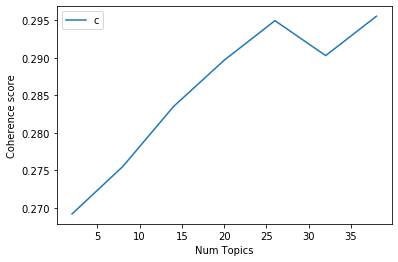

In [49]:
# Show graph
import matplotlib.pyplot as plt

limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [80]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2742
Num Topics = 8  has Coherence Value of 0.2801
Num Topics = 14  has Coherence Value of 0.2975
Num Topics = 20  has Coherence Value of 0.2833
Num Topics = 26  has Coherence Value of 0.2842
Num Topics = 32  has Coherence Value of 0.2941
Num Topics = 38  has Coherence Value of 0.2799


In [81]:
import spacy

nlp = spacy.load('en_core_web_lg')

/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/neural/train.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, SGD, linear_decay
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Sequence, Sized, Iterable, Callable
/Users/jonathansokoll/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/thinc/check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Sequence, Sized, Iterable, Callable


In [83]:
test = "Ned ask me a question about England today."

In [84]:
doc = nlp(test)

for token in doc:
    print(token.text, token.lemma_, token.pos_)

Ned ned PROPN
ask ask VERB
me -PRON- PRON
a a DET
question question NOUN
about about ADP
England england PROPN
today today NOUN
. . PUNCT


In [85]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Ned PERSON
England GPE
today DATE


In [88]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            yield text

def get_people(docstream):
    
    ppl = []
    in
    for d in docstream:
        
        doc = nlp(d)
        
        for ent in doc.ents:
            
            if ent.label_ == "PERSON":
                ppl.append(ent.text)
                
    return set(ppl)

In [89]:
people = get_people(doc_stream(path))

In [92]:
people = pd.Series(list(people))

In [94]:
people.head(50)

0                     Prudence
1           another Lucy Snowe
2                 Lydia Bennet
3                       J.E.\n
4                   Lucy Snowe
5                      \nJesus
6              Stilton\ncheese
7                  William Cox
8                       Paynim
9                    Bon\nsoir
10                       Ruben
11                    St. Matt
12                  Will Polly
13            Lady Middleton's
14               Bill Oliver's
15                    Robert\n
16                        Chut
17                   M. Paul's
18                Sarah Martha
19                      Trista
20            Ginevra Fanshawe
21                    Ferndean
22                   \nFanny's
23                   Scotchman
24                  \nEnscombe
25      John\nKnightley)--your
26       Cette malle est a moi
27                Brocklehurst
28                        Kint
29               \nGeorgette's
30                    M. Brown
31                \ndeceit!--I
32      

## Additional Resources
## Resources

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)